# 1. Build fitting function to the find the gac with different adsorption capacities.

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

def freundlich(x,n,kf):
    return kf*x**(1/n)

def langmuir(x,Q,kl):
    y = Q*(x*kl)/(1+x*kl)
    return y

In [84]:
from sklearn.metrics import r2_score

def fitting(df:pd.DataFrame):
    results = []
    index = set(df['Index'].values.tolist())
    for ind in index:
        temp_result = []
        temp_df = df[df['Index']==ind]
        xdata = temp_df['Pressure']
        ydata = temp_df['Adsorp(mmol/g)']
        poptf, _ = curve_fit(freundlich, xdata, ydata,maxfev=1000)
        Q1 = freundlich([10], *poptf)
        y_pred = freundlich(xdata, *poptf)
        R_f = r2_score(ydata, y_pred)
        try:
            poptl, _ = curve_fit(langmuir, xdata, ydata,maxfev=1000)
            y_pred = langmuir(xdata, *poptl)
            R_l = r2_score(ydata, y_pred)
        except:
            poptl = [-1,-1]
            R_l = -1
        temp_result.extend(list(poptf)+[R_f])
        temp_result.extend(Q1)
        temp_result.extend(list(poptl)+[R_l])
        temp_result.append(ind)
        results.append(temp_result)
    return pd.DataFrame(results,columns = ['n','kf','R_f','Q10','Q','kl','R_l','Index'])    

# 2. Data importing

In [85]:
import os 
BET_path = 'C:/Kai_Zhang/MachineLearning/Unified gas Adsorption/Treated/Methane'

def pred_dataset(file_names):
    source_path = 'C:/Kai_Zhang/MachineLearning/Unified gas Adsorption/CO2_adsorption/new_data'
    train_df = pd.DataFrame()
    for file_name in file_names:
        temp_data = pd.read_excel(os.path.join(source_path,file_name+'-02-02-2022.xlsx'),skiprows= 1 )
        #temp_data = temp_data.dropna(axis=0,how = 'any',subset = feature_set)
        train_df = pd.concat([train_df,temp_data],axis=0)
    return train_df

# 3. Generating fitted results

In [91]:
data = pred_dataset(['CO2'])

In [92]:
fitt_result = fitting(data)

In [93]:
fitt_result.to_csv('./11_simulated_experiments/CO2_fitting_results_Q10.csv')

In [94]:
fitt_result['Q10'].quantile(0.9)

25.57424337438821

# 4. Model training and make prediction for different selection from the datasets

In [57]:
# data pretreatment by splitting the data into training and the external validation
import os 
import pandas as pd
from sklearn.utils import shuffle
#BET_path = 'C:/Kai_Zhang/MachineLearning/Unified gas Adsorption/Treated/Methane'

def pred_datasets(file_names,percentile=0.1):
    #source_path = 'C:/Kai_Zhang/MachineLearning/Unified gas Adsorption/CO2_adsorption/new_data'
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    for file_name in file_names:
        temp_data = pd.read_csv(file_name+'_Adding_bet_35.csv')
        temp_data.dropna(axis=0,how="any",subset = ["BET","Vt","Vmic","BET_34"],inplace=True)
        #temp_data = temp_data.dropna(axis=0,how = 'any',subset = feature_set)
        fitted_results = pd.read_csv(os.path.join('./11_simulated_experiments/',file_name+'_fitting_results_Q10.csv'))
        fitted_results = fitted_results[fitted_results['Index'].isin(list(set(temp_data['Index'].values.tolist())))]
        thresh_index = 'Q10'
        threshold = fitted_results[thresh_index].quantile(percentile)
        if percentile>0.5:  
            test_index = fitted_results[fitted_results[thresh_index]>=threshold]['Index'].values.tolist()
            
        else:
            test_index = fitted_results[fitted_results[thresh_index]<=threshold]['Index'].values.tolist()
        cut_off = max(50,len(test_index)//2)
        print('Cut_off: ',cut_off,len(test_index))
        test_index = shuffle(test_index,random_state=43)[:cut_off]
        train_split = temp_data.loc[~temp_data['Index'].isin(test_index)]
        test_split = temp_data.loc[temp_data['Index'].isin(test_index)]
        train_df = pd.concat([train_df,train_split],axis=0)
        test_df = pd.concat([test_df,test_split],axis=0)
        #fitted_results.to_csv('Methane_fitted_with_all_properties.csv')

    return train_df,test_df

In [39]:
train_df,test_df = pred_datasets(['Methane'])

Cut_off:  50 56


# 5. Model training and prediction

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,\
    BaggingRegressor,ExtraTreesRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor  
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
  
n_estimators = [50,100,120,150,180,200,300]

# define different models#,
models = [
    #('SVR',SVR(max_iter=100000)),
    #('DT',DecisionTreeRegressor(random_state=42)),\
    # ('ADBR',AdaBoostRegressor(random_state=42)), 
    #("GBR",GradientBoostingRegressor(random_state=42)),\
    #('BG',BaggingRegressor(random_state=42,n_jobs=-1)),
    ('ETR',ExtraTreesRegressor(random_state=42,n_jobs=-1)),\
    #('RF',RandomForestRegressor(n_jobs=-1,random_state=42)),
    ('LGBM',LGBMRegressor(n_jobs = -1,random_state = 42)),\
    #('MLPR',MLPRegressor(random_state=42))
    #('BGLGBM',BaggingRegressor(LGBMRegressor(n_estimators = 200, n_jobs = -1,random_state = 42), random_state=42,n_jobs=-1)),\
    #('BGETR',BaggingRegressor(ExtraTreesRegressor(n_estimators = 180,random_state=42,n_jobs=6),random_state=42,n_jobs=-1))
    ]

# set search parameters grid for different models
para_grids = { 
    'SVR':{'kernel':['linear','poly','rbf','sigmoid','precomputed']},\
    'DT':{'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']},\
    'ADBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2],'loss':['linear','square','exponential']},\
    'GBR':{'n_estimators':n_estimators,'learning_rate':[0.1,0.5,1,2]},\
    'BG':{'n_estimators':[10,50,100]},\
    'ETR':{'n_estimators':n_estimators},\
    'RF':{'n_estimators':n_estimators},\
    'LGBM':{'num_leaves':[10,20,30,50,],'learning_rate': [0.05,0.1,0.5,1],'n_estimators':n_estimators},\
    'BGLGBM':{'n_estimators':[10,30,50]},\
    'BGETR':{'n_estimators':[10]},\
    'MLPR':{'hidden_layer_sizes':[(4,100),(5,100),(6,100)],
            "activation":["logistic","relu"],\
            "solver":['sgd', 'adam']}
    }

In [3]:
from sklearn.model_selection import GridSearchCV,cross_validate,GroupKFold
from sklearn.ensemble import ExtraTreesRegressor
from  sklearn.metrics import mean_squared_error,r2_score
from sklearn.utils import shuffle

def model_CV(train_x,train_y,groups,model,para_grid):

    out_cv = GroupKFold(n_splits = 5)
    result = GridSearchCV(model,para_grid,cv= out_cv.get_n_splits(groups =groups),
    scoring='neg_mean_squared_error', return_train_score=True,n_jobs=-1)
    result.fit(train_x,train_y)
    model_refit =model.set_params(**result.best_params_)
    train_cv = cross_validate(model_refit,train_x,train_y,groups = groups,cv =out_cv,scoring = ('r2', 'neg_mean_squared_error'))
    train_mse_cv = -train_cv['test_neg_mean_squared_error'].mean()
    train_r2_cv = train_cv['test_r2'].mean()
    return [train_r2_cv,train_mse_cv],result.best_params_

# model evaluation
def model_eval(model,test_x,test_y):
      
    test_pre = model.predict(test_x)
    test_r2 = r2_score(test_pre,test_y)
    test_mse = mean_squared_error(test_y,test_pre)
    return test_r2,test_mse

# comparing different models
def model_comparison(model_list,para_grids,feature_list,gas_list):
    gas_list = gas_list 
    input_feature = feature_list
    output = ['Adsorp(mmol/g)']
    result_total = []
    for gas in gas_list:
        if gas =='total':
            train_df_com = train_df
            test_df_com = test_df
            train_x = train_df_com[input_feature]
            test_x = test_df_com[input_feature]
            train_y = train_df_com[output].values
            test_y = test_df_com[output].values
            groups = train_df_com['Index'].values
            train_x, train_y, groups = shuffle(train_x, train_y, groups, random_state=42)
            
            for model_name, model in model_list:
                result, best_param = model_CV(train_x,train_y.squeeze(),groups,model,para_grids[model_name])
                model_refit = model.set_params(**best_param)
                model_refit.fit(train_x,train_y.squeeze())
                test_r2_total,test_mse_total = model_eval(model_refit,test_x,test_y.squeeze()) 
                for gases in gas_list[1:]:
                    test_df_com = test_df[test_df['Label']==gases]
                    test_xs = test_df_com[input_feature]
                    test_ys = test_df_com[output].values
                    test_r2,test_mse = model_eval(model_refit,test_xs,test_ys.squeeze()) 
                    result_total.append([gases,model_name+'_total',result[0],result[1],test_r2_total,test_mse_total,test_r2,test_mse,best_param])
                    print('Dataset {}, Algorithm {}, Test_r2 {}, Test_error {}'.format(gas,model_name+'_total',test_r2,test_mse))    
        else:
            train_df_com = train_df[train_df['Label']==gas]
            test_df_com = test_df[test_df['Label']==gas]
            train_x = train_df_com[input_feature]
            test_x = test_df_com[input_feature]
            train_y = train_df_com[output].values
            test_y = test_df_com[output].values
            groups = train_df_com['Index']
            train_x, train_y, groups = shuffle(train_x, train_y, groups, random_state=42)
            for model_name, model in model_list:
                result, best_param = model_CV(train_x,train_y.squeeze(),groups,model,para_grids[model_name])
                model_refit = model.set_params(**best_param)
                model_refit.fit(train_x,train_y.squeeze())
                test_r2,test_mse = model_eval(model_refit,test_x,test_y.squeeze()) 
                result_total.append([gas,model_name+'_separate',result[0],result[1],-1,-1, test_r2,test_mse,best_param])
                print('Dataset {}, Algorithm {}, Test_r2 {}, Test_error {}'.format(gas,model_name+'_total',test_r2,test_mse))  

    return result_total,model_refit.predict(test_x).reshape(-1,1),test_y

In [58]:
import os
conditions = ['S','V','Temp(K)','Pressure']
base_feature = ["BET_"+str(i) for i in range(35)]+conditions
feature_list = [base_feature+["BET","Vt","Vmic","Vmeso"]]
columns = ['Gas','Model_name','CV_r2','CV_mse','test_r2_total_model','test_mse_by_total_model','test_r2_separa_model','test_mse_separa_model','best_param']
file_name = ["BET_Curve_BET_Vt_Vmic_Vmeso"]
gas_list = ['CO2']#,'CFCs','Methane','E&E'

for i in range(1):
    train_df,test_df = pred_datasets(gas_list,.8)
    print(len(set(train_df['Index'].values)),len(set(test_df['Index'].values)))
    for j in range(len(feature_list)):
        results,y_pred,y_real = model_comparison(models,para_grids, feature_list[j],gas_list)
        files_name = '35_point_curve_feature_'+file_name[j]+'_result_'+str(i)+'.csv'
        pd.DataFrame(results,columns = columns).to_csv(os.path.join('./11_simulated_experiments',files_name)) 
    print("The finish of {} th trial".format(i)) 

Cut_off:  145 291
1308 145
Dataset CO2, Algorithm ETR_total, Test_r2 0.8710766682274603, Test_error 0.395731977481945
Dataset CO2, Algorithm LGBM_total, Test_r2 0.9277239349597327, Test_error 0.23495805286418722
The finish of 0 th trial


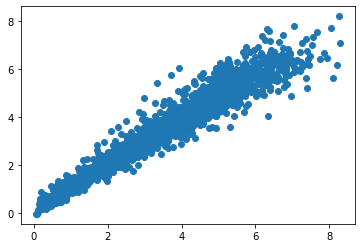

In [59]:
import matplotlib.pyplot as plt
plt.scatter(y_real,y_pred)

In [53]:
res= pd.DataFrame()
res["pred"]= y_pred.tolist()
res['real'] = y_real.tolist()
res.to_csv("CO2_half_top_0.8.csv")

In [13]:
from sklearn.utils import shuffle
x = shuffle([1,2,4])
x

[2, 1, 4]